In [1]:
import pandas as pd
import os

# Define paths
repo_path = 'dataset'
csv_path = os.path.join(repo_path, 'data', 'legend.csv')
images_path = os.path.join(repo_path, 'images')

# Load the CSV
df = pd.read_csv(csv_path)

# Inspect the first few rows to understand column names (e.g., 'image', 'emotion')
print("First 5 rows of the dataset:")
print(df.head())

# Check the shape of the dataset
print(f"\nTotal number of images: {len(df)}")

First 5 rows of the dataset:
  user.id                            image   emotion
0     628  facial-expressions_2868588k.jpg     anger
1     628  facial-expressions_2868585k.jpg  surprise
2     628  facial-expressions_2868584k.jpg   disgust
3     628  facial-expressions_2868582k.jpg      fear
4   dwdii           Aaron_Eckhart_0001.jpg   neutral

Total number of images: 13690


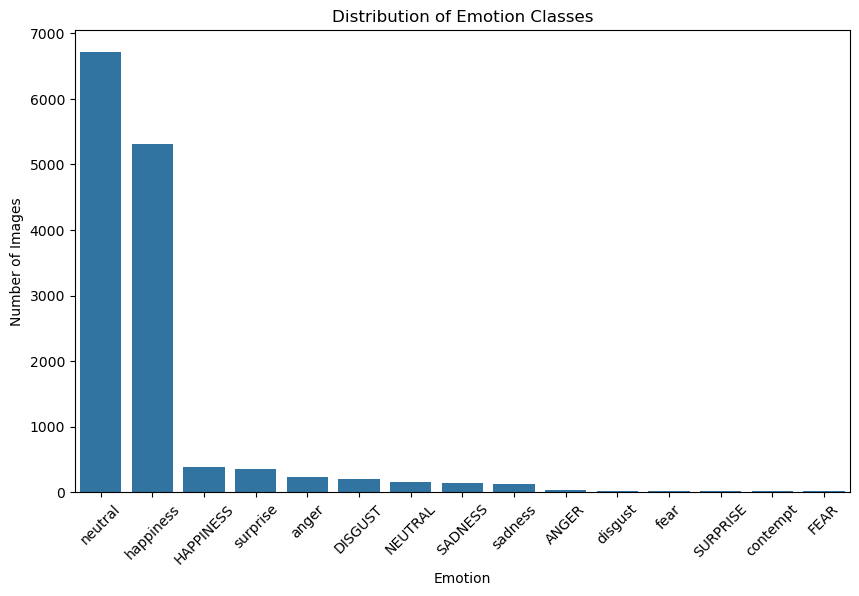

emotion
neutral      6717
happiness    5309
HAPPINESS     387
surprise      356
anger         228
DISGUST       195
NEUTRAL       151
SADNESS       144
sadness       124
ANGER          24
disgust        13
fear           13
SURPRISE       12
contempt        9
FEAR            8
Name: count, dtype: int64


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of emotions
plt.figure(figsize=(10, 6))
sns.countplot(x='emotion', data=df, order=df['emotion'].value_counts().index)
plt.title('Distribution of Emotion Classes')
plt.xlabel('Emotion')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

# Print the exact counts
print(df['emotion'].value_counts())

USE Data Augementation and Class Weighting to fix class imbalance

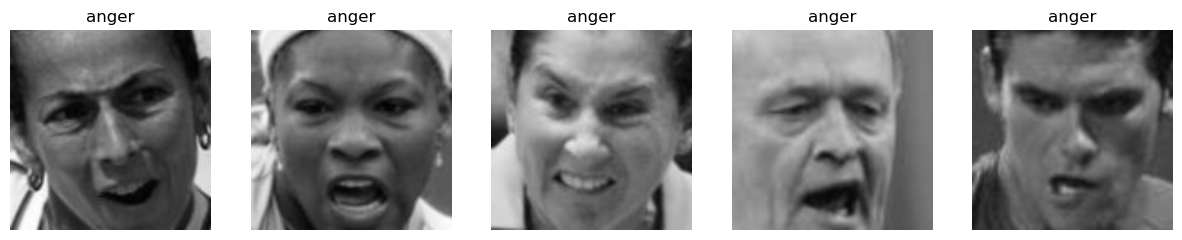

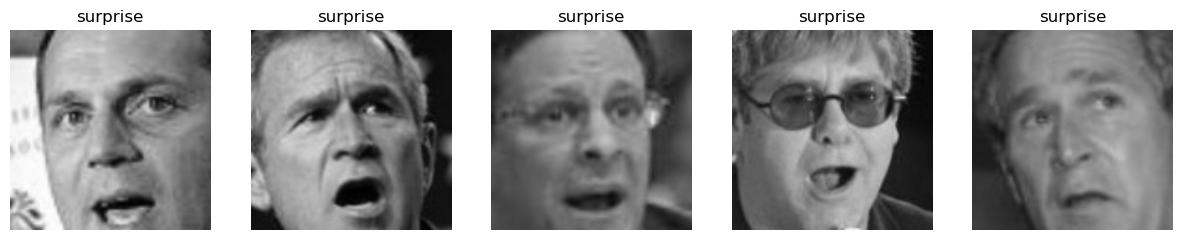

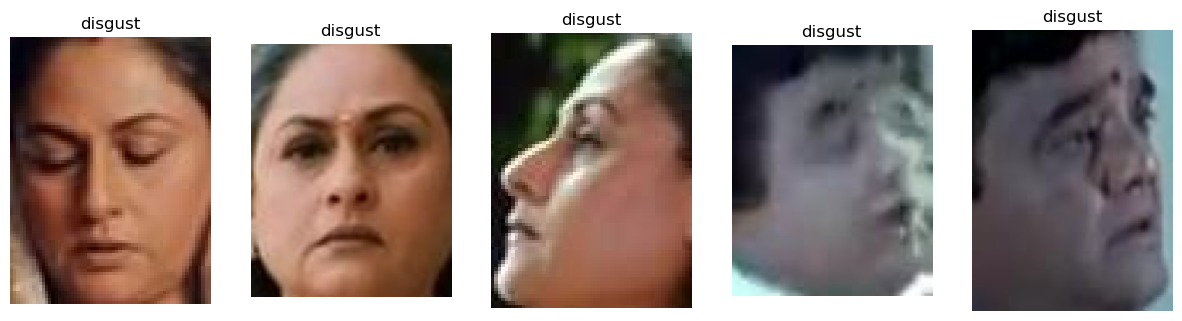

In [3]:
import cv2
import random

def show_samples(df, emotion_name, num_samples=5):
    # Filter df for the specific emotion
    emotion_df = df[df['emotion'].str.lower() == emotion_name.lower()]
    
    # Get random samples
    if len(emotion_df) < num_samples:
        samples = emotion_df['image'].values
    else:
        samples = random.sample(list(emotion_df['image'].values), num_samples)
    
    plt.figure(figsize=(15, 5))
    for i, img_name in enumerate(samples):
        img_path = os.path.join(images_path, img_name)
        
        # Read image (opencv reads in BGR, convert to RGB for plotting)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.subplot(1, num_samples, i+1)
            plt.imshow(img)
            plt.title(emotion_name)
            plt.axis('off')
        else:
            print(f"Could not load {img_name}")
    plt.show()

# Show examples for a few common emotions
unique_emotions = df['emotion'].unique()
for emotion in unique_emotions[:3]: # Show first 3 categories
    show_samples(df, emotion)

In [4]:
# Check the shape of the first loaded image
first_image_name = df.iloc[0]['image']
img = cv2.imread(os.path.join(images_path, first_image_name))

if img is not None:
    print(f"Original Image Shape: {img.shape}") 
    # Output will be (Height, Width, Channels)
else:
    print("Error loading image.")

Original Image Shape: (536, 347, 3)


In [5]:
# Convert all emotion labels to lowercase to merge categories like 'happiness' and 'HAPPINESS'
df['emotion'] = df['emotion'].str.lower()

# Verify the new distribution
print("New Class Distribution:")
print(df['emotion'].value_counts())

New Class Distribution:
emotion
neutral      6868
happiness    5696
surprise      368
sadness       268
anger         252
disgust       208
fear           21
contempt        9
Name: count, dtype: int64


In [6]:
import cv2
import numpy as np

def is_valid_image(img_name, base_path):
    img_path = os.path.join(base_path, img_name)
    if not os.path.exists(img_path):
        return False
    try:
        # Try loading the image
        img = cv2.imread(img_path)
        return img is not None
    except:
        return False

print(f"Original Row Count: {len(df)}")
df['valid'] = df['image'].apply(lambda x: is_valid_image(x, images_path))
df_clean = df[df['valid']].copy()

print(f"Cleaned Row Count: {len(df_clean)}")
print(f"Removed {len(df) - len(df_clean)} corrupted/missing images.")

Original Row Count: 13690
Cleaned Row Count: 13690
Removed 0 corrupted/missing images.


In [7]:
from sklearn.model_selection import train_test_split

# Split into Training (80%) and Test (20%)
# stratify=df_clean['emotion'] ensures every class is represented in both sets
train_df, test_df = train_test_split(
    df_clean, 
    test_size=0.2, 
    stratify=df_clean['emotion'], 
    random_state=42
)

# Further split Train into Train (85%) and Validation (15%)
train_df, val_df = train_test_split(
    train_df, 
    test_size=0.15, 
    stratify=train_df['emotion'], 
    random_state=42
)

print(f"Train Size: {len(train_df)}")
print(f"Validation Size: {len(val_df)}")
print(f"Test Size: {len(test_df)}")

Train Size: 9309
Validation Size: 1643
Test Size: 2738


In [8]:
from sklearn.utils.class_weight import compute_class_weight

classes = sorted(train_df['emotion'].unique())

weights = compute_class_weight(
    class_weight='balanced', 
    classes=np.array(classes), 
    y=train_df['emotion']
)

class_weight_dict = dict(zip(classes, weights))

print("Class Weights (Higher number = Model tries harder to learn this class):")
for emotion, weight in class_weight_dict.items():
    print(f"{emotion}: {weight:.2f}")

Class Weights (Higher number = Model tries harder to learn this class):
anger: 6.77
contempt: 193.94
disgust: 8.25
fear: 83.12
happiness: 0.30
neutral: 0.25
sadness: 6.36
surprise: 4.65


In [9]:
def analyze_image_properties(df, images_path, sample_size=1000):
    """
    Analyze image properties: resolution, color channels, pixel intensities
    """
    # Sample images to speed up analysis
    sample_df = df.sample(n=min(sample_size, len(df)), random_state=42)
    
    resolutions = []
    is_grayscale = []
    mean_intensities = []
    std_intensities = []
    
    print("Analyzing image properties...")
    for idx, row in sample_df.iterrows():
        img_path = os.path.join(images_path, row['image'])
        img = cv2.imread(img_path)
        
        if img is not None:
            h, w, c = img.shape
            resolutions.append((h, w))
            
            # Check if grayscale (all channels identical)
            if c == 3:
                is_gray = np.allclose(img[:,:,0], img[:,:,1]) and np.allclose(img[:,:,1], img[:,:,2])
                is_grayscale.append(is_gray)
            else:
                is_grayscale.append(True)
            
            # Calculate pixel statistics
            mean_intensities.append(np.mean(img))
            std_intensities.append(np.std(img))
    
    return resolutions, is_grayscale, mean_intensities, std_intensities

# Run the analysis
resolutions, is_grayscale, mean_intensities, std_intensities = analyze_image_properties(
    df_clean, images_path, sample_size=1000
)

Analyzing image properties...


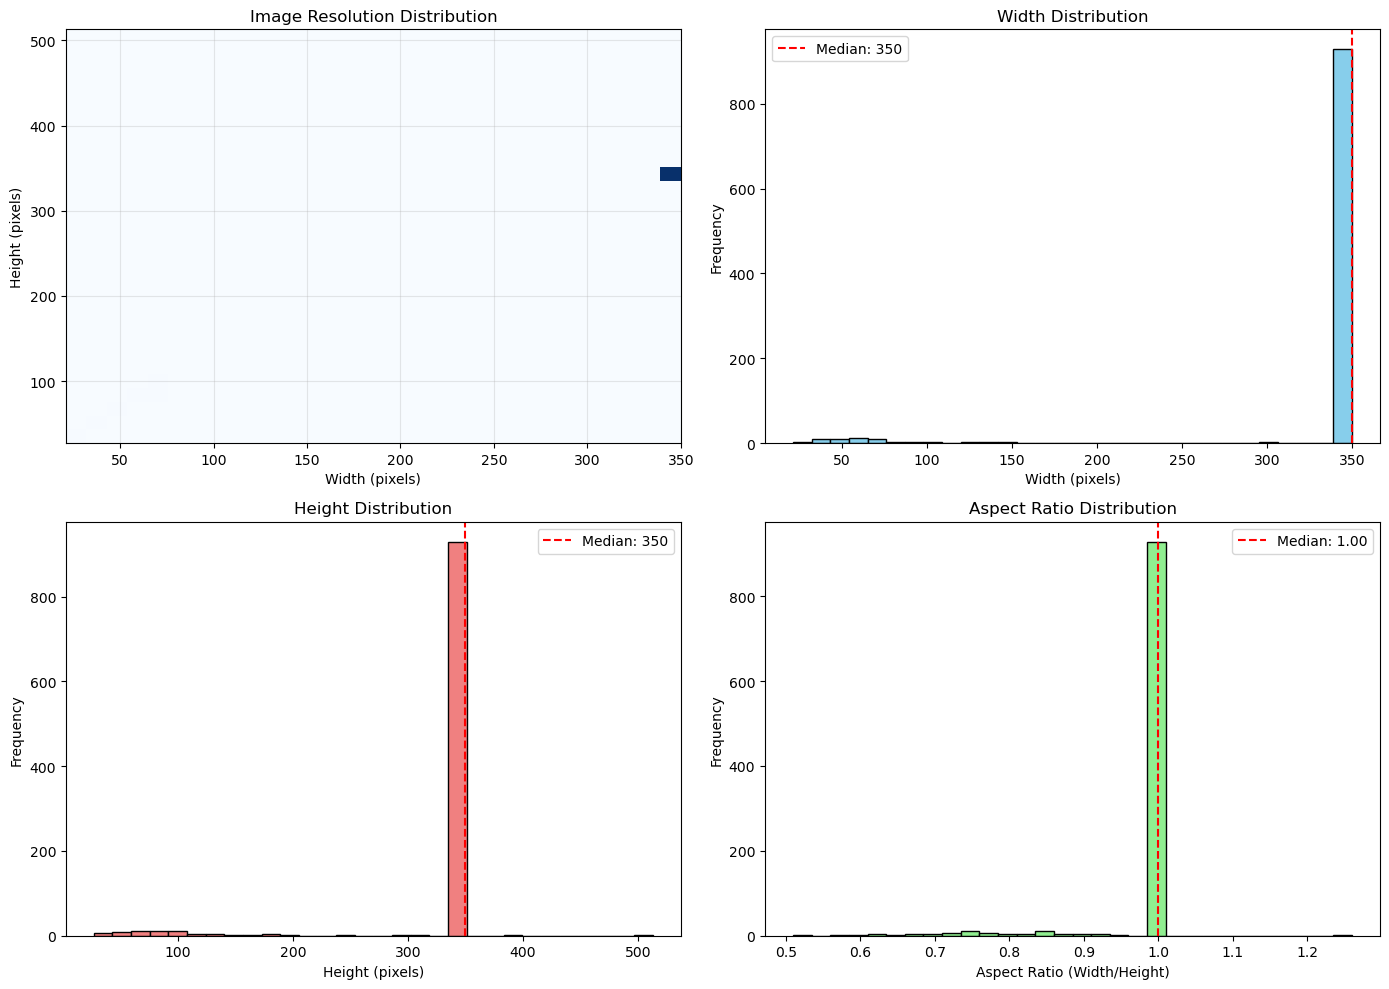


 Image Resolution Statistics:
   Width - Mean: 331.4, Median: 350.0, Std: 69.4
   Height - Mean: 333.5, Median: 350.0, Std: 65.1
   Most common resolution: (350, 350)


In [10]:
# Extract heights and widths
heights = [r[0] for r in resolutions]
widths = [r[1] for r in resolutions]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Resolution histogram
axes[0, 0].hist2d(widths, heights, bins=30, cmap='Blues')
axes[0, 0].set_xlabel('Width (pixels)')
axes[0, 0].set_ylabel('Height (pixels)')
axes[0, 0].set_title('Image Resolution Distribution')
axes[0, 0].grid(True, alpha=0.3)

# Width distribution
axes[0, 1].hist(widths, bins=30, color='skyblue', edgecolor='black')
axes[0, 1].set_xlabel('Width (pixels)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Width Distribution')
axes[0, 1].axvline(np.median(widths), color='red', linestyle='--', label=f'Median: {np.median(widths):.0f}')
axes[0, 1].legend()

# Height distribution
axes[1, 0].hist(heights, bins=30, color='lightcoral', edgecolor='black')
axes[1, 0].set_xlabel('Height (pixels)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Height Distribution')
axes[1, 0].axvline(np.median(heights), color='red', linestyle='--', label=f'Median: {np.median(heights):.0f}')
axes[1, 0].legend()

# Aspect ratio distribution
aspect_ratios = [w/h for w, h in zip(widths, heights)]
axes[1, 1].hist(aspect_ratios, bins=30, color='lightgreen', edgecolor='black')
axes[1, 1].set_xlabel('Aspect Ratio (Width/Height)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Aspect Ratio Distribution')
axes[1, 1].axvline(np.median(aspect_ratios), color='red', linestyle='--', label=f'Median: {np.median(aspect_ratios):.2f}')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

print(f"\n Image Resolution Statistics:")
print(f"   Width - Mean: {np.mean(widths):.1f}, Median: {np.median(widths):.1f}, Std: {np.std(widths):.1f}")
print(f"   Height - Mean: {np.mean(heights):.1f}, Median: {np.median(heights):.1f}, Std: {np.std(heights):.1f}")
print(f"   Most common resolution: {max(set(resolutions), key=resolutions.count)}")

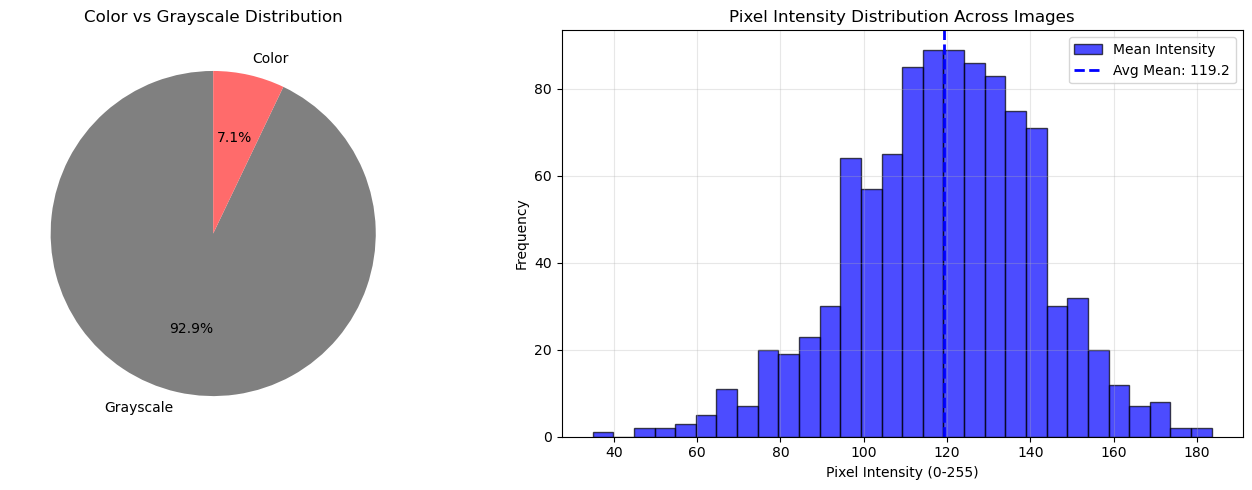


Color Analysis:
   Grayscale images: 929 (92.9%)
   Color images: 71 (7.1%)
   Mean pixel intensity: 119.18 ± 22.43


In [11]:
grayscale_count = sum(is_grayscale)
color_count = len(is_grayscale) - grayscale_count

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart
colors_pie = ['#808080', '#FF6B6B']
axes[0].pie([grayscale_count, color_count], 
            labels=['Grayscale', 'Color'], 
            autopct='%1.1f%%',
            colors=colors_pie,
            startangle=90)
axes[0].set_title('Color vs Grayscale Distribution')

# Pixel intensity distribution
axes[1].hist(mean_intensities, bins=30, alpha=0.7, label='Mean Intensity', color='blue', edgecolor='black')
axes[1].axvline(np.mean(mean_intensities), color='blue', linestyle='--', linewidth=2, label=f'Avg Mean: {np.mean(mean_intensities):.1f}')
axes[1].set_xlabel('Pixel Intensity (0-255)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Pixel Intensity Distribution Across Images')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nColor Analysis:")
print(f"   Grayscale images: {grayscale_count} ({grayscale_count/len(is_grayscale)*100:.1f}%)")
print(f"   Color images: {color_count} ({color_count/len(is_grayscale)*100:.1f}%)")
print(f"   Mean pixel intensity: {np.mean(mean_intensities):.2f} ± {np.std(mean_intensities):.2f}")

/var/folders/yl/19nbcjt104gdn52x50k4b_sm0000gn/T/ipykernel_71450/687250356.py:33: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot(intensities_by_emotion, labels=emotions)


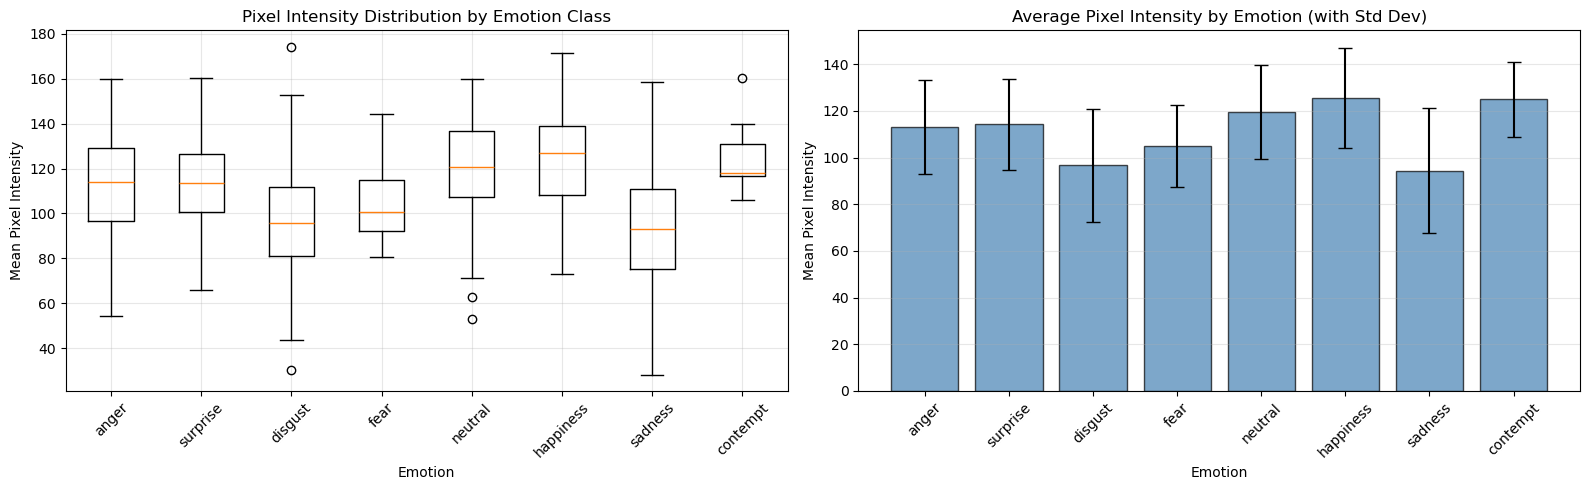


💡 Pixel Intensity by Emotion:
   Anger: 113.23 ± 20.20
   Contempt: 125.00 ± 16.07
   Disgust: 96.72 ± 24.19
   Fear: 104.87 ± 17.58
   Happiness: 125.58 ± 21.57
   Neutral: 119.48 ± 20.17
   Sadness: 94.44 ± 26.65
   Surprise: 114.20 ± 19.57


In [12]:
def get_emotion_pixel_stats(df, images_path, sample_per_class=100):
    """Get pixel intensity statistics per emotion class"""
    emotion_stats = {}
    
    for emotion in df['emotion'].unique():
        emotion_df = df[df['emotion'] == emotion]
        sample = emotion_df.sample(n=min(sample_per_class, len(emotion_df)), random_state=42)
        
        intensities = []
        for idx, row in sample.iterrows():
            img_path = os.path.join(images_path, row['image'])
            img = cv2.imread(img_path)
            if img is not None:
                intensities.append(np.mean(img))
        
        emotion_stats[emotion] = {
            'mean': np.mean(intensities),
            'std': np.std(intensities),
            'intensities': intensities
        }
    
    return emotion_stats

emotion_pixel_stats = get_emotion_pixel_stats(df_clean, images_path)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Box plot
emotions = list(emotion_pixel_stats.keys())
intensities_by_emotion = [emotion_pixel_stats[e]['intensities'] for e in emotions]

axes[0].boxplot(intensities_by_emotion, labels=emotions)
axes[0].set_xlabel('Emotion')
axes[0].set_ylabel('Mean Pixel Intensity')
axes[0].set_title('Pixel Intensity Distribution by Emotion Class')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3)

# Bar plot with error bars
means = [emotion_pixel_stats[e]['mean'] for e in emotions]
stds = [emotion_pixel_stats[e]['std'] for e in emotions]

axes[1].bar(emotions, means, yerr=stds, capsize=5, alpha=0.7, color='steelblue', edgecolor='black')
axes[1].set_xlabel('Emotion')
axes[1].set_ylabel('Mean Pixel Intensity')
axes[1].set_title('Average Pixel Intensity by Emotion (with Std Dev)')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n💡 Pixel Intensity by Emotion:")
for emotion in sorted(emotions):
    stats = emotion_pixel_stats[emotion]
    print(f"   {emotion.capitalize()}: {stats['mean']:.2f} ± {stats['std']:.2f}")

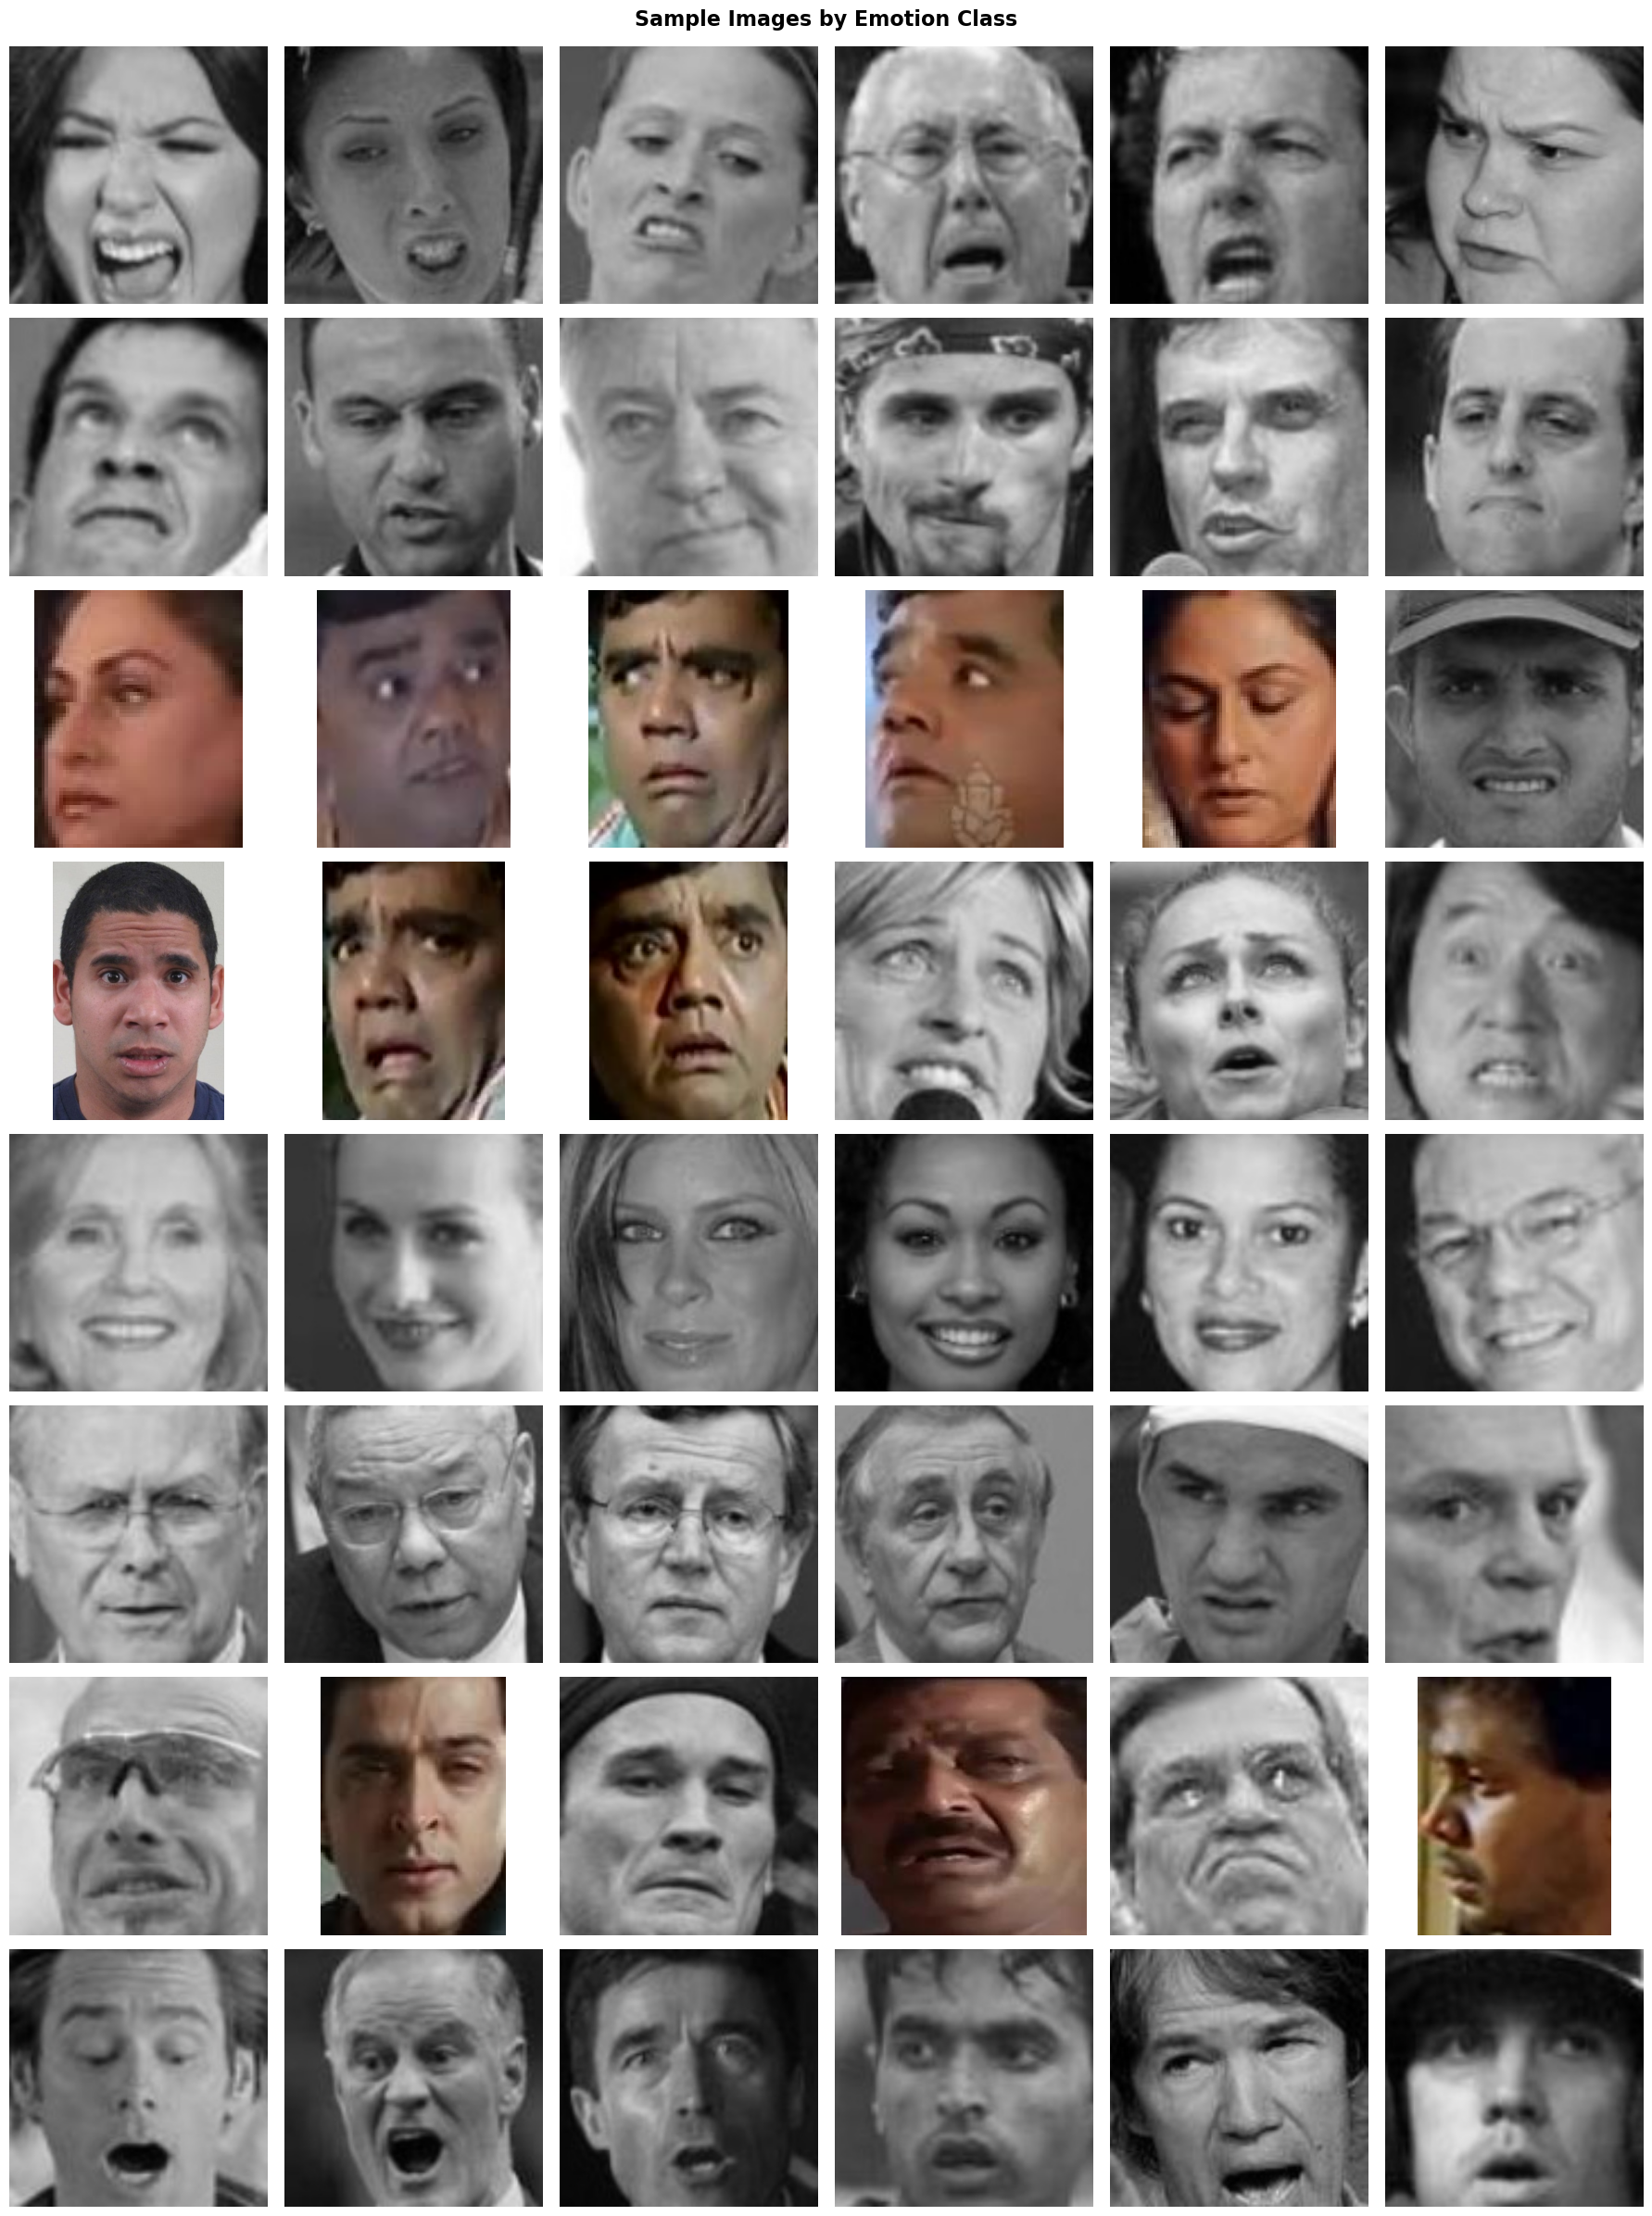

In [13]:
def create_emotion_grid(df, images_path, samples_per_emotion=6):
    """Create a comprehensive grid showing samples from each emotion"""
    emotions = sorted(df['emotion'].unique())
    n_emotions = len(emotions)
    
    fig, axes = plt.subplots(n_emotions, samples_per_emotion, figsize=(18, 3*n_emotions))
    
    if n_emotions == 1:
        axes = axes.reshape(1, -1)
    
    for i, emotion in enumerate(emotions):
        emotion_df = df[df['emotion'] == emotion]
        samples = emotion_df.sample(n=min(samples_per_emotion, len(emotion_df)), random_state=42)
        
        for j, (idx, row) in enumerate(samples.iterrows()):
            if j >= samples_per_emotion:
                break
                
            img_path = os.path.join(images_path, row['image'])
            img = cv2.imread(img_path)
            
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                axes[i, j].imshow(img)
                axes[i, j].axis('off')
                
                if j == 0:
                    axes[i, j].set_ylabel(emotion.capitalize(), fontsize=12, weight='bold')
            else:
                axes[i, j].text(0.5, 0.5, 'Error', ha='center', va='center')
                axes[i, j].axis('off')
    
    plt.suptitle('Sample Images by Emotion Class', fontsize=16, weight='bold', y=0.995)
    plt.tight_layout()
    plt.show()

create_emotion_grid(df_clean, images_path, samples_per_emotion=6)

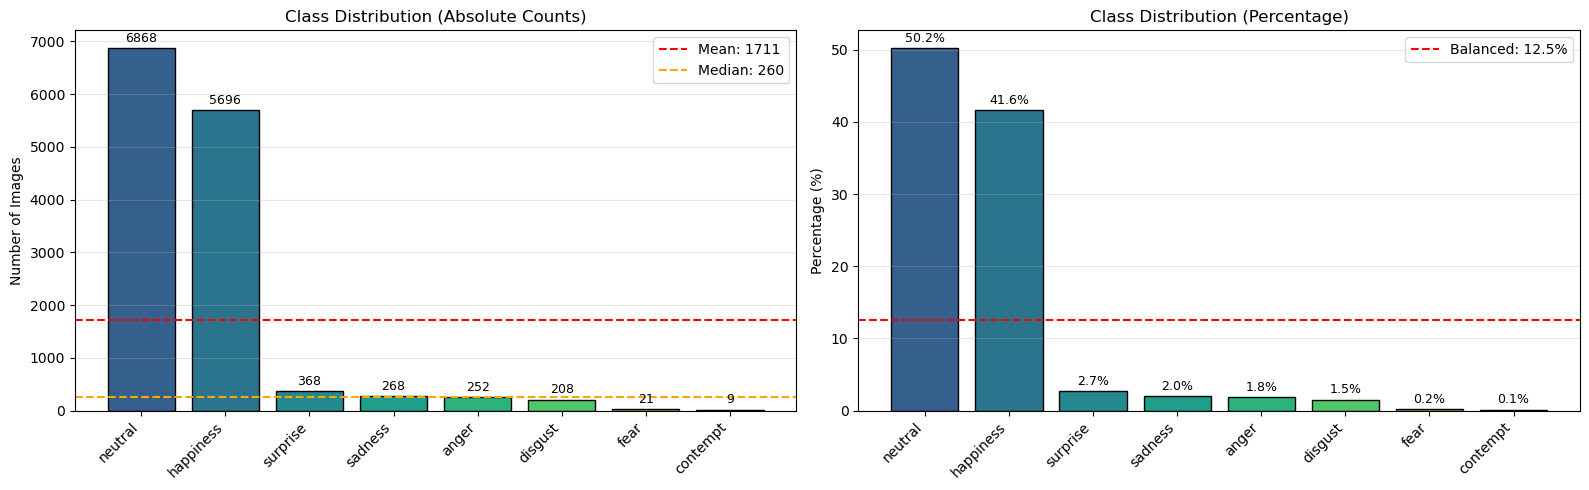


Class Imbalance Analysis:
   Number of classes: 8
   Most common class: neutral (6868 images)
   Least common class: contempt (9 images)
   Imbalance ratio: 763.11x
   Mean images per class: 1711.2
   Std dev: 2841.1

   HIGH IMBALANCE DETECTED (ratio > 3)
   Recommended strategies:
   - Use class weights in loss function ✓ (already computed)
   - Apply data augmentation more heavily to minority classes
   - Consider Focal Loss instead of CrossEntropy


In [14]:
# Calculate imbalance metrics
emotion_counts = df_clean['emotion'].value_counts()
max_count = emotion_counts.max()
min_count = emotion_counts.min()
imbalance_ratio = max_count / min_count

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Enhanced bar plot with reference lines
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(emotion_counts)))
axes[0].bar(range(len(emotion_counts)), emotion_counts.values, color=colors, edgecolor='black')
axes[0].set_xticks(range(len(emotion_counts)))
axes[0].set_xticklabels(emotion_counts.index, rotation=45, ha='right')
axes[0].set_ylabel('Number of Images')
axes[0].set_title('Class Distribution (Absolute Counts)')
axes[0].axhline(y=emotion_counts.mean(), color='red', linestyle='--', label=f'Mean: {emotion_counts.mean():.0f}')
axes[0].axhline(y=emotion_counts.median(), color='orange', linestyle='--', label=f'Median: {emotion_counts.median():.0f}')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Add count labels on bars
for i, (emotion, count) in enumerate(emotion_counts.items()):
    axes[0].text(i, count + max_count*0.01, str(count), ha='center', va='bottom', fontsize=9)

# Percentage distribution
percentages = (emotion_counts / emotion_counts.sum() * 100)
axes[1].bar(range(len(percentages)), percentages.values, color=colors, edgecolor='black')
axes[1].set_xticks(range(len(percentages)))
axes[1].set_xticklabels(percentages.index, rotation=45, ha='right')
axes[1].set_ylabel('Percentage (%)')
axes[1].set_title('Class Distribution (Percentage)')
axes[1].axhline(y=100/len(emotion_counts), color='red', linestyle='--', label=f'Balanced: {100/len(emotion_counts):.1f}%')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

# Add percentage labels
for i, (emotion, pct) in enumerate(percentages.items()):
    axes[1].text(i, pct + percentages.max()*0.01, f'{pct:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print(f"\nClass Imbalance Analysis:")
print(f"   Number of classes: {len(emotion_counts)}")
print(f"   Most common class: {emotion_counts.index[0]} ({emotion_counts.iloc[0]} images)")
print(f"   Least common class: {emotion_counts.index[-1]} ({emotion_counts.iloc[-1]} images)")
print(f"   Imbalance ratio: {imbalance_ratio:.2f}x")
print(f"   Mean images per class: {emotion_counts.mean():.1f}")
print(f"   Std dev: {emotion_counts.std():.1f}")

if imbalance_ratio > 3:
    print(f"\n   HIGH IMBALANCE DETECTED (ratio > 3)")
    print(f"   Recommended strategies:")
    print(f"   - Use class weights in loss function ✓ (already computed)")
    print(f"   - Apply data augmentation more heavily to minority classes")
    print(f"   - Consider Focal Loss instead of CrossEntropy")
elif imbalance_ratio > 1.5:
    print(f"\n   MODERATE IMBALANCE (ratio > 1.5)")
    print(f"   Recommended: Use class weights (already computed)")
else:
    print(f"\n   Classes are relatively balanced")

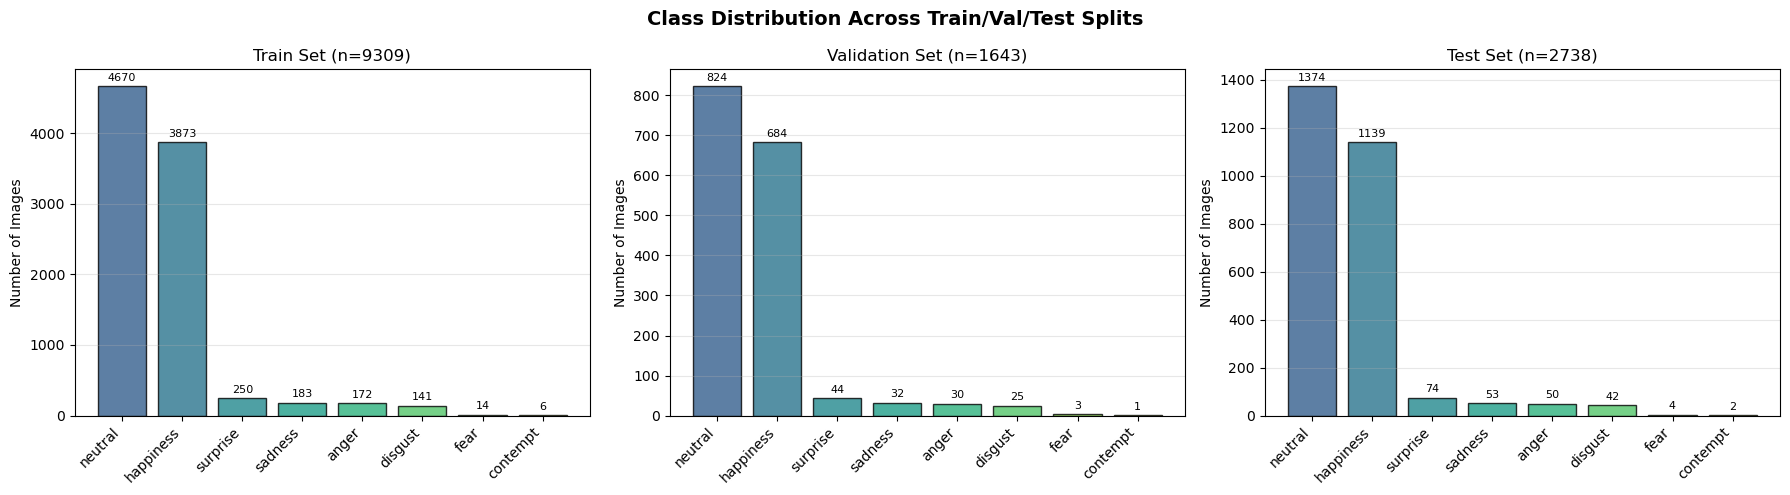


Split Verification (all splits should have similar proportions):

Proportions by emotion:
           Train %  Val %  Test %
emotion                          
anger         1.85   1.83    1.83
contempt      0.06   0.06    0.07
disgust       1.51   1.52    1.53
fear          0.15   0.18    0.15
happiness    41.60  41.63   41.60
neutral      50.17  50.15   50.18
sadness       1.97   1.95    1.94
surprise      2.69   2.68    2.70


In [15]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

splits = [
    ('Train', train_df),
    ('Validation', val_df),
    ('Test', test_df)
]

for idx, (split_name, split_df) in enumerate(splits):
    counts = split_df['emotion'].value_counts()
    
    axes[idx].bar(range(len(counts)), counts.values, color=colors, edgecolor='black', alpha=0.8)
    axes[idx].set_xticks(range(len(counts)))
    axes[idx].set_xticklabels(counts.index, rotation=45, ha='right')
    axes[idx].set_ylabel('Number of Images')
    axes[idx].set_title(f'{split_name} Set (n={len(split_df)})')
    axes[idx].grid(True, alpha=0.3, axis='y')
    
    # Add count labels
    for i, count in enumerate(counts.values):
        axes[idx].text(i, count + counts.max()*0.01, str(count), ha='center', va='bottom', fontsize=8)

plt.suptitle('Class Distribution Across Train/Val/Test Splits', fontsize=14, weight='bold')
plt.tight_layout()
plt.show()

# Verify stratification worked
print("\nSplit Verification (all splits should have similar proportions):")
print("\nProportions by emotion:")
comparison_df = pd.DataFrame({
    'Train %': (train_df['emotion'].value_counts() / len(train_df) * 100).sort_index(),
    'Val %': (val_df['emotion'].value_counts() / len(val_df) * 100).sort_index(),
    'Test %': (test_df['emotion'].value_counts() / len(test_df) * 100).sort_index()
})
print(comparison_df.round(2))

In [16]:
from skimage.feature import hog
from skimage import exposure
from tqdm import tqdm

def extract_hog_features(df, base_path, target_size=(64, 64)):
    features = []
    labels = []
    
    print(f"Extracting HOG features for {len(df)} images...")
    
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        img_path = os.path.join(base_path, row['image'])
        
        # 1. Load Image (Grayscale is sufficient for HOG/shape detection)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        if img is not None:
            # 2. RESIZE (Critical Step)
            img_resized = cv2.resize(img, target_size)
            
            # 3. Compute HOG
            # orientations=9, pixels_per_cell=(8, 8) are standard values
            fd = hog(img_resized, orientations=9, pixels_per_cell=(8, 8),
                     cells_per_block=(2, 2), visualize=False)
            
            features.append(fd)
            labels.append(row['emotion'])
            
    return np.array(features), np.array(labels)

# Run extraction on Train and Test sets
# Note: We use 64x64 to keep feature vector size manageable (~1700 features per image)
X_train_hog, y_train_hog = extract_hog_features(train_df, images_path, target_size=(64, 64))
X_test_hog, y_test_hog = extract_hog_features(test_df, images_path, target_size=(64, 64))

print(f"Feature Vector Shape: {X_train_hog.shape}")

Extracting HOG features for 9309 images...


100%|██████████| 9309/9309 [00:30<00:00, 308.41it/s]


Extracting HOG features for 2738 images...


100%|██████████| 2738/2738 [00:10<00:00, 256.94it/s]


Feature Vector Shape: (9309, 1764)


In [17]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Initialize SVM with RBF kernel and balanced class weights
svm_model = SVC(
    kernel='rbf', 
    class_weight='balanced',  # This handles the imbalance automatically
    C=1.0,                    # Regularization parameter
    random_state=42,
    verbose=True
)

print("Training SVM... (This might take a few minutes)")
svm_model.fit(X_train_hog, y_train_hog)
print("Training Complete.")

Training SVM... (This might take a few minutes)
[LibSVM]*.*
optimization finished, #iter = 188
obj = -16.307885, rho = -0.918785
nSV = 112, nBSV = 0
.*
optimization finished, #iter = 466
obj = -91.412501, rho = 0.968633
nSV = 247, nBSV = 0
*.*
optimization finished, #iter = 226
obj = -32.592343, rho = -0.774893
nSV = 131, nBSV = 0
.*
optimization finished, #iter = 1684
obj = -305.743802, rho = 0.951042
nSV = 1276, nBSV = 718
..*
optimization finished, #iter = 2494
obj = -430.398490, rho = 0.677709
nSV = 1946, nBSV = 1284
.*
optimization finished, #iter = 703
obj = -181.150948, rho = 0.649679
nSV = 336, nBSV = 0
.*
optimization finished, #iter = 748
obj = -203.011381, rho = -0.061474
nSV = 355, nBSV = 0
*
optimization finished, #iter = 140
obj = -12.409728, rho = 0.995595
nSV = 91, nBSV = 0
.*.*
optimization finished, #iter = 40
obj = -9.577574, rho = 0.400164
nSV = 20, nBSV = 0
*
optimization finished, #iter = 326
obj = -19.095855, rho = 1.096509
nSV = 204, nBSV = 9
*
optimization fini


Classification Report:
              precision    recall  f1-score   support

       anger       0.37      0.28      0.32        50
    contempt       0.00      0.00      0.00         2
     disgust       0.35      0.67      0.46        42
        fear       0.00      0.00      0.00         4
   happiness       0.84      0.85      0.84      1139
     neutral       0.85      0.83      0.84      1374
     sadness       0.30      0.17      0.22        53
    surprise       0.28      0.36      0.32        74

    accuracy                           0.80      2738
   macro avg       0.37      0.39      0.37      2738
weighted avg       0.80      0.80      0.80      2738



/opt/anaconda3/envs/cs178/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/cs178/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/cs178/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.sh

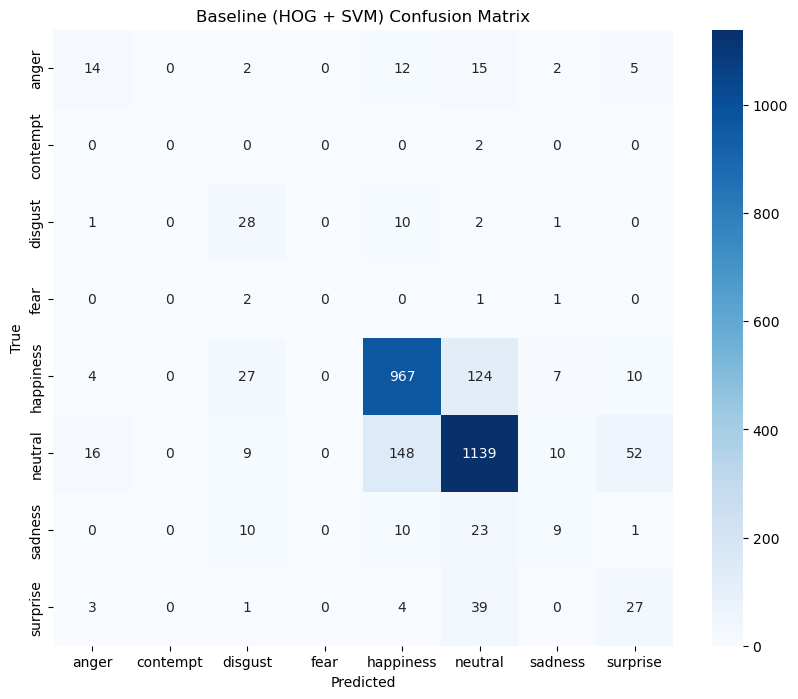

In [18]:
# Predictions
y_pred = svm_model.predict(X_test_hog)

# 1. Classification Report (Precision/Recall per class)
print("\nClassification Report:")
print(classification_report(y_test_hog, y_pred))

# 2. Confusion Matrix
cm = confusion_matrix(y_test_hog, y_pred, labels=classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Baseline (HOG + SVM) Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()